In [1]:
from __future__ import print_function, division
import os, bz2, json, time, sys, csv
from datetime import timedelta, datetime

import math
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats as stats

from matplotlib import pyplot as plt
from tqdm import tqdm

from util_read import engage_read, read_vids, engage_tweets_read, merge_engage_tweets, engage_metadata, compute_period_daily

In [2]:
plt.rcParams.update({'axes.labelsize': 20, 
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

In [3]:
file_vids_filter_all = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv" 
engage_dataset_base = "/localdata/u6314203/dataset_engage16/tweeted_videos" 
tweets_dataset_base = "/localdata/u6314203/dataset_tweets_engage/dataset_tweets_fixTZ"

# file_vids_filter_all = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
# engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"
# tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_fixTZ"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [4]:
# vids from all category
vids_filter_all = read_vids(file_vids_filter_all)

merged_dataset = dict()
# engage_metadata = dict() 
for category in categories_eligible[:]:
    engage_dataset = engage_read(engage_dataset_base, category)
    tweets_dataset = engage_tweets_read(tweets_dataset_base, category)
    
    curr_merged = merge_engage_tweets(engage_dataset, tweets_dataset)
    merged_dataset.update(curr_merged)
    
print(f"Total size: {len(merged_dataset)}")

Vids(filtered) in each category:
autos:25712; comedy:31741; education:41191; entertainment:180128; film:43101; gaming:222236; howto:61027; music:118094; news:38249; people:222658; science:32278; sports:39649; travel:13112
Engage autos size: 25139
Tweets autos size: 25597
Merged size: 25030
Engage comedy size: 31519
Tweets comedy size: 31678
Merged size: 31456
Engage education size: 40311
Tweets education size: 41005
Merged size: 40126
Engage entertainment size: 177236
Tweets entertainment size: 179517
Merged size: 176636
Engage film size: 42439
Tweets film size: 42954
Merged size: 42295
Engage gaming size: 219709
Tweets gaming size: 221470
Merged size: 218958
Engage howto size: 59965
Tweets howto size: 60796
Merged size: 59740
Engage music size: 116884
Tweets music size: 117764
Merged size: 116559
Engage news size: 37508
Tweets news size: 38082
Merged size: 37344
Engage people size: 220100
Tweets people size: 221975
Merged size: 219427
Engage science size: 31899
Tweets science size: 32

In [5]:
timepoint = 90
pearsonr_vals = []
vids = []
for k, vals in merged_dataset.items():
    series_views = vals["viewCounts"][timepoint:]
    series_tweets = vals["tweets"][timepoint:]
    r, p = stats.pearsonr(series_views, series_tweets)
    pearsonr_vals.append([r,p,np.mean(series_views),np.mean(series_tweets)])
    vids.append(k)

df_pearsonr = pd.DataFrame(pearsonr_vals, columns=["r", "p", "daily views", "daily tweets"], index=vids)
df_pearsonr = df_pearsonr[[not x for x in np.isnan(df_pearsonr["r"])]]
pd.DataFrame.describe(df_pearsonr)

/home/users/u6314203/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,r,p,daily views,daily tweets
count,360823.000000,3.608230e+05,3.608230e+05,360823.000000
mean,0.073639,4.177376e-01,6.481652e+02,0.064733
std,0.138165,3.261082e-01,1.430357e+04,1.455822
min,-0.523183,4.220111e-319,4.587156e-03,0.004202
25%,-0.013536,8.644404e-02,1.702906e+01,0.005102
50%,0.041045,4.019324e-01,6.079621e+01,0.010000
75%,0.119346,7.081092e-01,2.360737e+02,0.024510
max,0.999506,1.000000e+00,4.997167e+06,436.808743


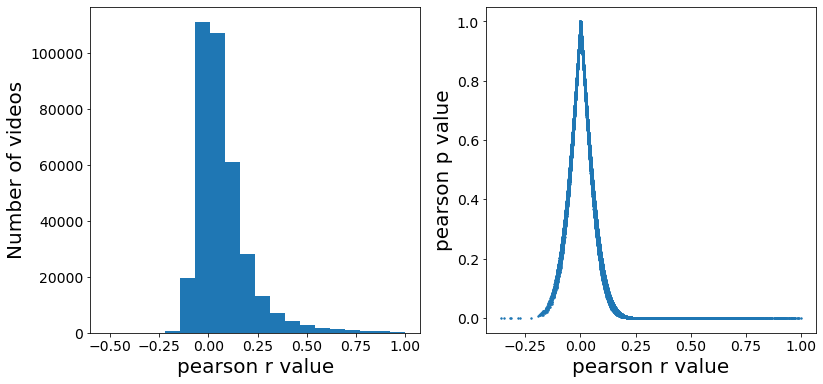

In [13]:
fig = plt.figure(figsize=(13, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_pearsonr["r"], bins=20)
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
sample_indices = np.random.choice(len(df_pearsonr["r"]), size=len(df_pearsonr["r"])//10, replace=False)
ax.scatter(df_pearsonr["r"][sample_indices], df_pearsonr["p"][sample_indices], s=2)
ax.set_xlabel("pearson r value")
ax.set_ylabel("pearson p value")

fig.savefig("figs/temporal_views_promotion/longTermPearson1.pdf", bbox_inches='tight')

In [7]:
df_filter = df_pearsonr[df_pearsonr["p"]<=0.05]

pd.DataFrame.describe(df_filter)

,r,p,daily views,daily tweets
count,76381.000000,7.638100e+04,7.638100e+04,76381.000000
mean,0.273429,9.702578e-03,1.499468e+03,0.173588
std,0.162700,1.378711e-02,3.038086e+04,2.865963
min,-0.523183,4.220111e-319,1.424084e+00,0.004202
25%,0.169993,3.668750e-06,2.177830e+01,0.009009
50%,0.219009,1.741270e-03,1.013661e+02,0.021390
75%,0.320137,1.574019e-02,4.966524e+02,0.072222
max,0.999506,4.999592e-02,4.997167e+06,436.808743


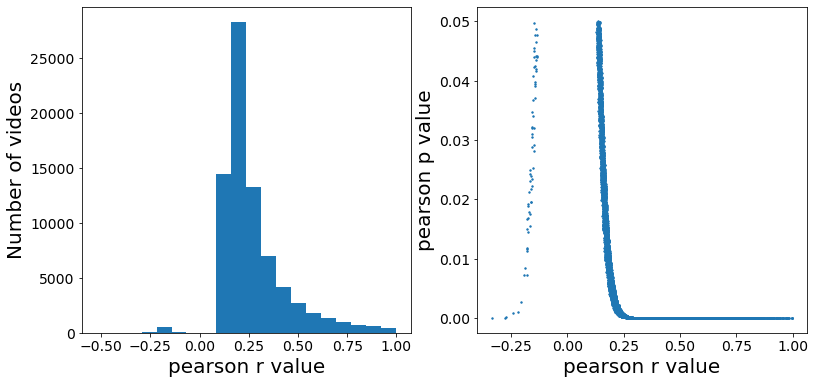

In [16]:
fig = plt.figure(figsize=(13, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_filter["r"], bins=20)
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
sample_indices = np.random.choice(len(df_filter["r"]), size=len(df_filter["r"])//10, replace=False)
ax.scatter(df_filter["r"][sample_indices], df_filter["p"][sample_indices], s=2)
ax.set_xlabel("pearson r value")
ax.set_ylabel("pearson p value")

fig.savefig("figs/temporal_views_promotion/longTermPearson2.pdf", bbox_inches='tight')

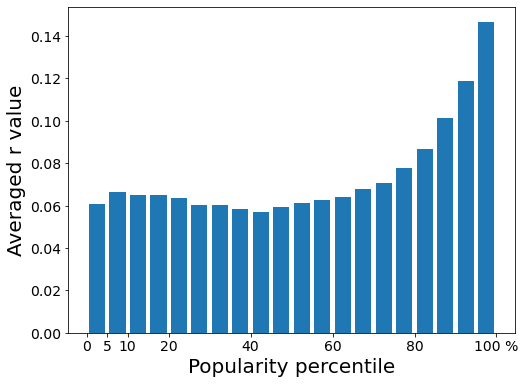

In [9]:
pd1 = df_pearsonr.sort_values(by=['daily views'])
edges = np.linspace(0, len(pd1.index), num=21)
pd1_bins = [pd1.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd1_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0", "5", "10", "20", "40", "60", "80", "100 %"])
ax.set_xlabel("Popularity percentile")
ax.set_ylabel("Averaged r value")

fig.savefig("figs/temporal_views_promotion/rvalue_popularity.pdf", bbox_inches='tight')
pass

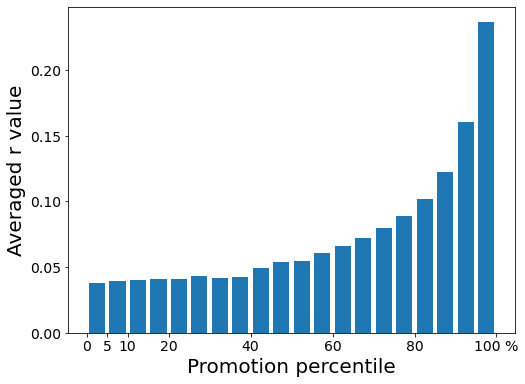

In [10]:
pd2 = df_pearsonr.sort_values(by=['daily tweets'])
edges = np.linspace(0, len(pd2.index), num=21)
pd2_bins = [pd2.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd2_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0", "5", "10", "20", "40", "60", "80", "100 %"])
ax.set_xlabel("Promotion percentile")
ax.set_ylabel("Averaged r value")

fig.savefig("figs/temporal_views_promotion/rvalue_promotion.pdf", bbox_inches='tight')
pass